# Spaceship Titanic Kaggle Competition
My attempt at this Kaggle Competition [link](https://www.kaggle.com/competitions/spaceship-titanic/data)

In [157]:
%pip install kaggle pandas numpy matplotlib scikit-learn > /dev/null

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


## Downloading Dataset

In [10]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import zipfile

# Create the data folder if it doesn't exist
os.makedirs('data', exist_ok=True)

# Authenticate and download the dataset files
api = KaggleApi()
api.authenticate()
api.competition_download_files('spaceship-titanic', path='data')

try: 
    with zipfile.ZipFile('data/spaceship-titanic.zip', 'r') as zip_ref:
        zip_ref.extractall('data')
except Exception as e:
    print('Could not unzip file', e)

In [108]:
data_raw_all = pd.read_csv('data/train.csv')
data_raw_val = pd.read_csv('data/test.csv')

In [109]:
data_raw_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


# Exploring Data

## Cabins

From the below it seems that each person is in a cabin 6561 cabins for 8693 people. Maybe it would be good to associate with each person `cabin_mates` which is equal to how many people are in their cabin with them.

In [110]:
len(data_raw_all['Cabin'].unique()), len(data_raw_all['Cabin'])

(6561, 8693)

In [111]:
data_raw_all[['Cabin', 'PassengerId']]

,Cabin,PassengerId
0,B/0/P,0001_01
1,F/0/S,0002_01
2,A/0/S,0003_01
3,A/0/S,0003_02
4,F/1/S,0004_01
...,...,...
8688,A/98/P,9276_01
8689,G/1499/S,9278_01
8690,G/1500/S,9279_01
8691,E/608/S,9280_01


In [123]:
joined_cabin_counts = pd.concat([data_raw_all, data_raw_val])[['Cabin', 'PassengerId']].groupby('Cabin').count()
joined_cabin_counts = joined_cabin_counts.rename(columns={'PassengerId': 'cabin_mates'})
joined_cabin_counts

data_raw_all_psg_cnt = data_raw_all.merge(cabin_counts, left_on='Cabin', right_on='Cabin')
data_raw_val_psg_cnt = data_raw_val.merge(cabin_counts_val, left_on='Cabin', right_on='Cabin')

In [124]:
data_raw_all_psg_cnt.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'cabin_mates'],
      dtype='object')

Text(0, 0.5, 'Frequency')

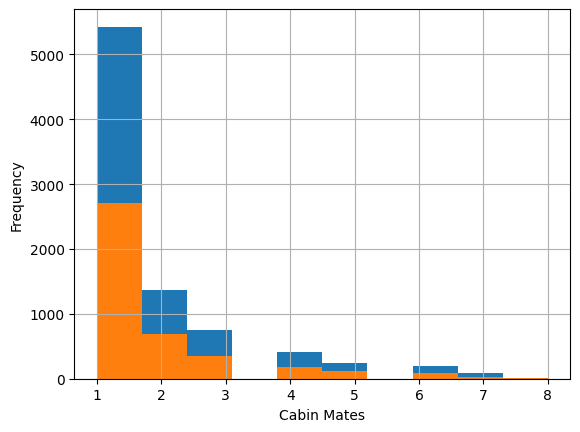

In [127]:
data_raw_all_psg_cnt['cabin_mates'].hist()
plt.xlabel("Cabin Mates")
plt.ylabel("Frequency")

data_raw_val_psg_cnt['cabin_mates'].hist()
plt.xlabel("Cabin Mates")
plt.ylabel("Frequency")

## Closer look at Cabin Numbers

It looks like cabin numbers have some underlying structure (for example: `G/1499/S` `B\0\P`). Let's try breaking them into columns and see if it is correlated

In [128]:
data_raw_all_psg_cnt[['c0', 'c1', 'c2']] = data_raw_all_psg_cnt['Cabin'].str.split('/', expand=True)
data_raw_all_psg_cnt['c1'] = data_raw_all_psg_cnt['c1'].astype(np.float64)

data_raw_val_psg_cnt[['c0', 'c1', 'c2']] = data_raw_val_psg_cnt['Cabin'].str.split('/', expand=True)
data_raw_val_psg_cnt['c1'] = data_raw_val_psg_cnt['c1'].astype(np.float64)

In [119]:
data_raw_all_psg_cnt['c0'].unique()

array(['B', 'F', 'A', 'G', 'E', 'D', 'C', 'T'], dtype=object)

<Axes: >

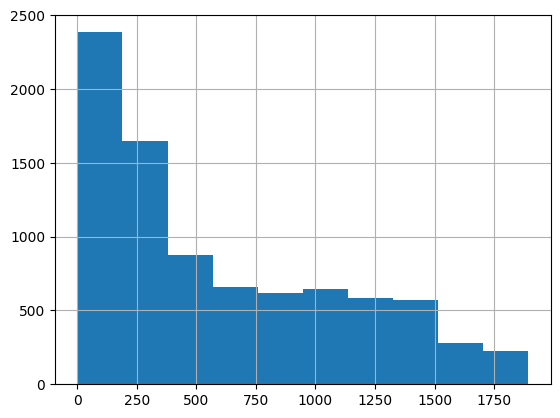

In [122]:
data_raw_all_psg_cnt['c1'].hist()

In [121]:
data_raw_all_psg_cnt['c2'].unique()

array(['P', 'S'], dtype=object)

## Names

In [165]:
data_raw_all_psg_cnt['Transported'].astype(np.int64)

0       0
1       1
2       0
3       0
4       1
       ..
8489    0
8490    0
8491    1
8492    0
8493    1
Name: Transported, Length: 8494, dtype: int64

In [184]:
from sklearn.preprocessing import OrdinalEncoder

data_raw_all_psg_cnt[['first_name', 'last_name']] = data_raw_all_psg_cnt['Name'].str.split(' ', expand=True)
data_raw_val_psg_cnt[['first_name', 'last_name']] = data_raw_val_psg_cnt['Name'].str.split(' ', expand=True)
# data_raw_all_psg_cnt['last_name'] = data_raw_all_psg_cnt['last_name'].to_numeric(row, errors='coerce')
# names.rename(columns={0: 'first_name', 1: 'last_name'}, inplace=True)

# data_raw_all_psg_cnt[['first_name', 'last_name', 'Transported']]

enc = OrdinalEncoder()
# enc_x = enc.fit_transform(data_raw_all_psg_cnt['last_name'].values.reshape(-1, 1))
def ln_length(row):
    if pd.isna(row['last_name']):
        return 0
    return len(row['last_name'])
def fn_length(row):
    if pd.isna(row['first_name']):
        return 0
    return len(row['first_name'])

data_raw_all_psg_cnt['ln_length'] = data_raw_all_psg_cnt.apply(ln_length, axis=1)
data_raw_all_psg_cnt['fn_length'] = data_raw_all_psg_cnt.apply(fn_length, axis=1)
data_raw_all_psg_cnt['y_enc'] = data_raw_all_psg_cnt['Transported'].astype(np.int64)

data_raw_val_psg_cnt['ln_length'] = data_raw_val_psg_cnt.apply(ln_length, axis=1)
data_raw_val_psg_cnt['fn_length'] = data_raw_val_psg_cnt.apply(fn_length, axis=1)

data_raw_all_psg_cnt[['ln_length', 'fn_length', 'y_enc']]

,ln_length,fn_length,y_enc
0,9,5,0
1,5,6,1
2,6,6,0
3,6,5,0
4,11,5,1
...,...,...,...
8489,9,7,0
8490,9,5,0
8491,6,5,1
8492,9,6,0


In [185]:
data_raw_val_psg_cnt[['ln_length', 'fn_length', 'y_enc']].corr()['y_enc']

KeyError: "['y_enc'] not in index"

### From the above name length does have some correlation with survival!

# Preprocessing

In [186]:
num_cols = ['Age', 'c1', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'cabin_mates', 'ln_length', 'fn_length']
str_cols = ['HomePlanet', 'c0', 'c2', 'Destination', 'CryoSleep', 'VIP']

removed_cols = ['Cabin', 'Name']

In [191]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Pipeline for categorical columns: Ordinal Encoding with NaN as a new category
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),  # Replace NaNs with "Missing"
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Encode categories
])

# Pipeline for numerical columns: Median imputation and scaling
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing values with median
    ('scaler', StandardScaler())  # Normalize numerical data
])

# Column Transformer: Applies different transformations to different column types
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, str_cols)
])

y_all = data_raw_all_psg_cnt['Transported'].astype(np.int64)
X_all = preprocessor.fit_transform(data_raw_all_psg_cnt)
X_val = preprocessor.transform(data_raw_val_psg_cnt)

X_all

array([[ 0.71251222, -1.17296632, -0.34237108, ...,  1.        ,
         0.        ,  3.        ],
       [-0.33354675, -1.17296632, -0.17065743, ...,  5.        ,
         1.        ,  3.        ],
       [ 2.03752026, -1.17296632, -0.27463083, ...,  0.        ,
         1.        ,  3.        ],
       ...,
       [-0.19407222,  1.75765363, -0.34237108, ...,  6.        ,
         1.        ,  3.        ],
       [ 0.22435137,  0.01491164, -0.34237108, ...,  4.        ,
         1.        ,  0.        ],
       [ 1.06119855,  0.01491164, -0.1438764 , ...,  4.        ,
         1.        ,  3.        ]], shape=(8494, 14))

In [193]:
from sklearn.model_selection import train_test_split

# Perform train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

len(X_train), len(X_test)

(6795, 1699)

# Classify

In [196]:
from sklearn.linear_model import LogisticRegression
lin_reg = LogisticRegression().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.7760117733627667 test_score=0.7822248381400824


In [197]:
from sklearn.linear_model import RidgeClassifier
lin_reg = RidgeClassifier().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.7311258278145696 test_score=0.72218952324897


In [198]:
from sklearn.linear_model import SGDClassifier
lin_reg = SGDClassifier().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.7751287711552612 test_score=0.7816362566215421


In [199]:
from sklearn.ensemble import AdaBoostClassifier
lin_reg = AdaBoostClassifier().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.7689477557027226 test_score=0.7916421424367275


In [200]:
from sklearn.ensemble import BaggingClassifier
lin_reg = BaggingClassifier().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.9864606328182487 test_score=0.8016480282519128


In [202]:
from sklearn.ensemble import GradientBoostingClassifier
lin_reg = GradientBoostingClassifier().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.8147167034584253 test_score=0.8128310771041789


In [203]:
from sklearn.ensemble import HistGradientBoostingClassifier
lin_reg = HistGradientBoostingClassifier().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.8885945548197204 test_score=0.8187168922895821


In [204]:
from sklearn.ensemble import RandomForestClassifier
lin_reg = RandomForestClassifier().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.9997056659308315 test_score=0.8193054738081225


In [205]:
from sklearn.naive_bayes import GaussianNB
lin_reg = GaussianNB().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.6896247240618102 test_score=0.6874632136550912


In [206]:
from sklearn.naive_bayes import BernoulliNB
lin_reg = BernoulliNB().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.7537895511405445 test_score=0.761035903472631


In [211]:
from sklearn.svm import LinearSVC
lin_reg = LinearSVC().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.7760117733627667 test_score=0.785167745732784


In [212]:
from sklearn.svm import NuSVC
lin_reg = NuSVC().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.798822663723326 test_score=0.8004708652148322


In [214]:
from sklearn.svm import SVR
lin_reg = SVR().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.427435646348595 test_score=0.4167742355561175


## BEST Classifier: RandomForestClassifier

Fine tuning time

In [138]:
data_raw_all_psg_cnt['Transported']

0       False
1        True
2       False
3       False
4        True
        ...  
8489    False
8490    False
8491     True
8492    False
8493     True
Name: Transported, Length: 8494, dtype: bool